<a href="https://colab.research.google.com/github/jjangmo91/eeSDM_Cervus-nippon/blob/main/eeSDM_Cervus_nippon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **eeSDM_Cervus-nippon**

In [22]:
%pip install -U -q eeSDM
%pip install -U -q pyarrow
%pip install -U -q geopandas
%pip install -U -q pycrs
%pip install -U -q statsmodels

In [23]:
import eeSDM
import ee, geemap
import geemap.colormaps as cm

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random, math, os

import warnings
warnings.filterwarnings("ignore")

In [24]:
# Earth Engine Authentication
ee.Authenticate()

# Initializing Earth Engine
ee.Initialize(project='ee-jjangmo91')

# 1. Add Species Occurrence Data(Local)

In [28]:
# CSV 파일 경로
url = "https://raw.githubusercontent.com/jjangmo91/eeSDM_Cervus-nippon/main/Cervus-nippon.csv"

# DataFrame 변환
df = pd.read_csv(url)
print(df.columns)

# GeoDataFrame 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = "EPSG:4326")

# GeoDataFrame을 Earth Engine 객체로 변환
data_raw = geemap.geopandas_to_ee(gdf)

# 공간 해상도 설정(m)
GrainSize = 30

# Geographic sampling bias 제한(하나 빼고 다 제거)

def remove_duplicates(data_raw, GrainSize):
    # Select one presence record per pixel at the chosen spatial resolution (1km) randomly
    # Generate a random raster image and reproject it to the specified coordinate system and resolution
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)

    # Sample presence points with the generated random raster
    # Scale parameter is set to 10 for sampling, geometries are included
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data_raw), scale=10, geometries=True)

    # Keep only distinct presence records based on the 'random' property
    return rand_point_vals.distinct('random')

Data = remove_duplicates(data_raw, GrainSize)

Index(['Species', 'Latitude', 'Longitude'], dtype='object')


# 2. Define Area of Interest (AOI)

In [29]:
# Define Area of Interest (AOI)
# Calculate the bounding box of the Data and expand it by 50,000 meters
AOI = Data.geometry().bounds().buffer(distance=50000, maxError=1000)

# Create an outline image of the AOI for visualization
outline = ee.Image().byte().paint(featureCollection=AOI, color=1, width=3)

# Creating an Empty geemap Map Object
Map = geemap.Map()

Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.addLayer(data_raw, {'color': 'blue'}, 'Original data')
Map.addLayer(Data, {'color': 'red'}, 'Final data')
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[36.55470083850744, 127.85726280645379], controls=(WidgetControl(options=['position', 'transparent_…

# 3. Add Predictive Variables

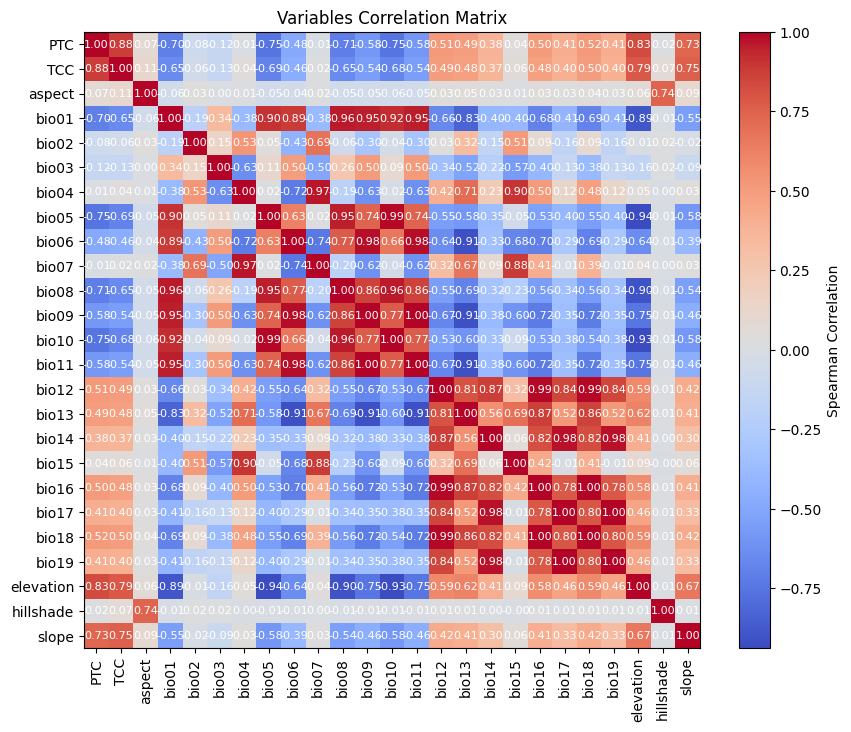

In [32]:
# WorldClim BIO Variables V1 (1km): A total of 19 climate variables
BIO = ee.Image("WORLDCLIM/V1/BIO")

# NASA SRTM Digital Elevation 30m: Digital elevation data
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

# MOD44B.006 Terra MODIS Vegetation Continuous Fields Yearly Global 250m
# Percent Tree Cover: Median between 2003 and 2020
MODIS = ee.ImageCollection("MODIS/006/MOD44B")
MedianPTC = MODIS.filterDate('2003-01-01', '2020-12-31').select(['Percent_Tree_Cover'], ['PTC']).median()

# TCC / Global Forest Cover Change(GFCC)
TCC = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
MedianTCC = TCC.filterDate('2000-01-01', '2015-12-31')
MedianTCC = MedianTCC.select(['tree_canopy_cover'], ['TCC']).median()

# Combining Bands into a Single Multi-Band Image
predictors = BIO.addBands(Terrain).addBands(MedianPTC).addBands(MedianTCC)

# 수역 마스크 생성
watermask =  Terrain.select('elevation').gt(0)

# 해양 픽셀 마스킹 및 관심 영역 클리핑
predictors = predictors.updateMask(watermask).clip(AOI)

# 다중 공선성 처리
DataCor = predictors.sample(scale=GrainSize, numPixels=5000, geometries=True) # Generating 5000 Random Locations
PixelVals = predictors.sampleRegions(collection=DataCor, scale=GrainSize, tileScale=16) # Extracting Covariate Values

# 공변량 값 ee를 df로 변환
PixelVals_df = geemap.ee_to_df(PixelVals)
PixelVals_df.head(1)

# Plot correlation heatmap
eeSDM.plot_correlation_heatmap(PixelVals_df)



In [33]:
# Perform filtering using VIF (Variance Inflation Factor)
# Apply the function to remove variables with high multicollinearity
# Obtain the list of remaining column names after VIF-based filtering
filtered_PixelVals_df, bands = eeSDM.filter_variables_by_vif(PixelVals_df)

Removing 'bio05' with VIF inf
Removing 'bio09' with VIF inf
Removing 'bio17' with VIF inf
Removing 'bio04' with VIF 562581.35
Removing 'bio16' with VIF 513578.47
Removing 'bio07' with VIF 242299.99
Removing 'bio10' with VIF 157928.72
Removing 'bio12' with VIF 100699.49
Removing 'bio08' with VIF 31163.68
Removing 'bio15' with VIF 23318.88
Removing 'bio02' with VIF 18024.12
Removing 'bio19' with VIF 5135.48
Removing 'bio18' with VIF 4303.29
Removing 'bio06' with VIF 3985.51
Removing 'bio13' with VIF 1946.64
Removing 'bio03' with VIF 1449.22
Removing 'bio14' with VIF 120.78
Removing 'hillshade' with VIF 41.91
Removing 'PTC' with VIF 21.10
Removing 'elevation' with VIF 11.62
Bands: ['TCC', 'aspect', 'bio01', 'bio11', 'slope']


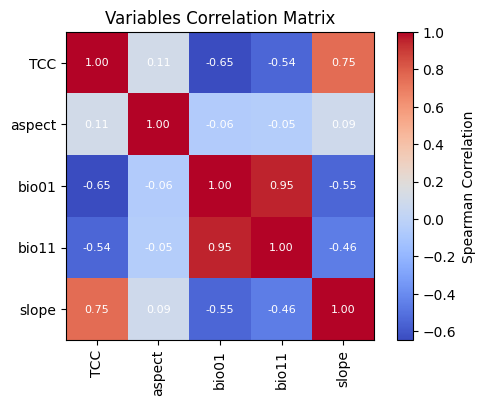

In [34]:
# Select only the bands (predictor variables) that remain after filtering
predictors = predictors.select(bands)

# Plot correlation heatmap
eeSDM.plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

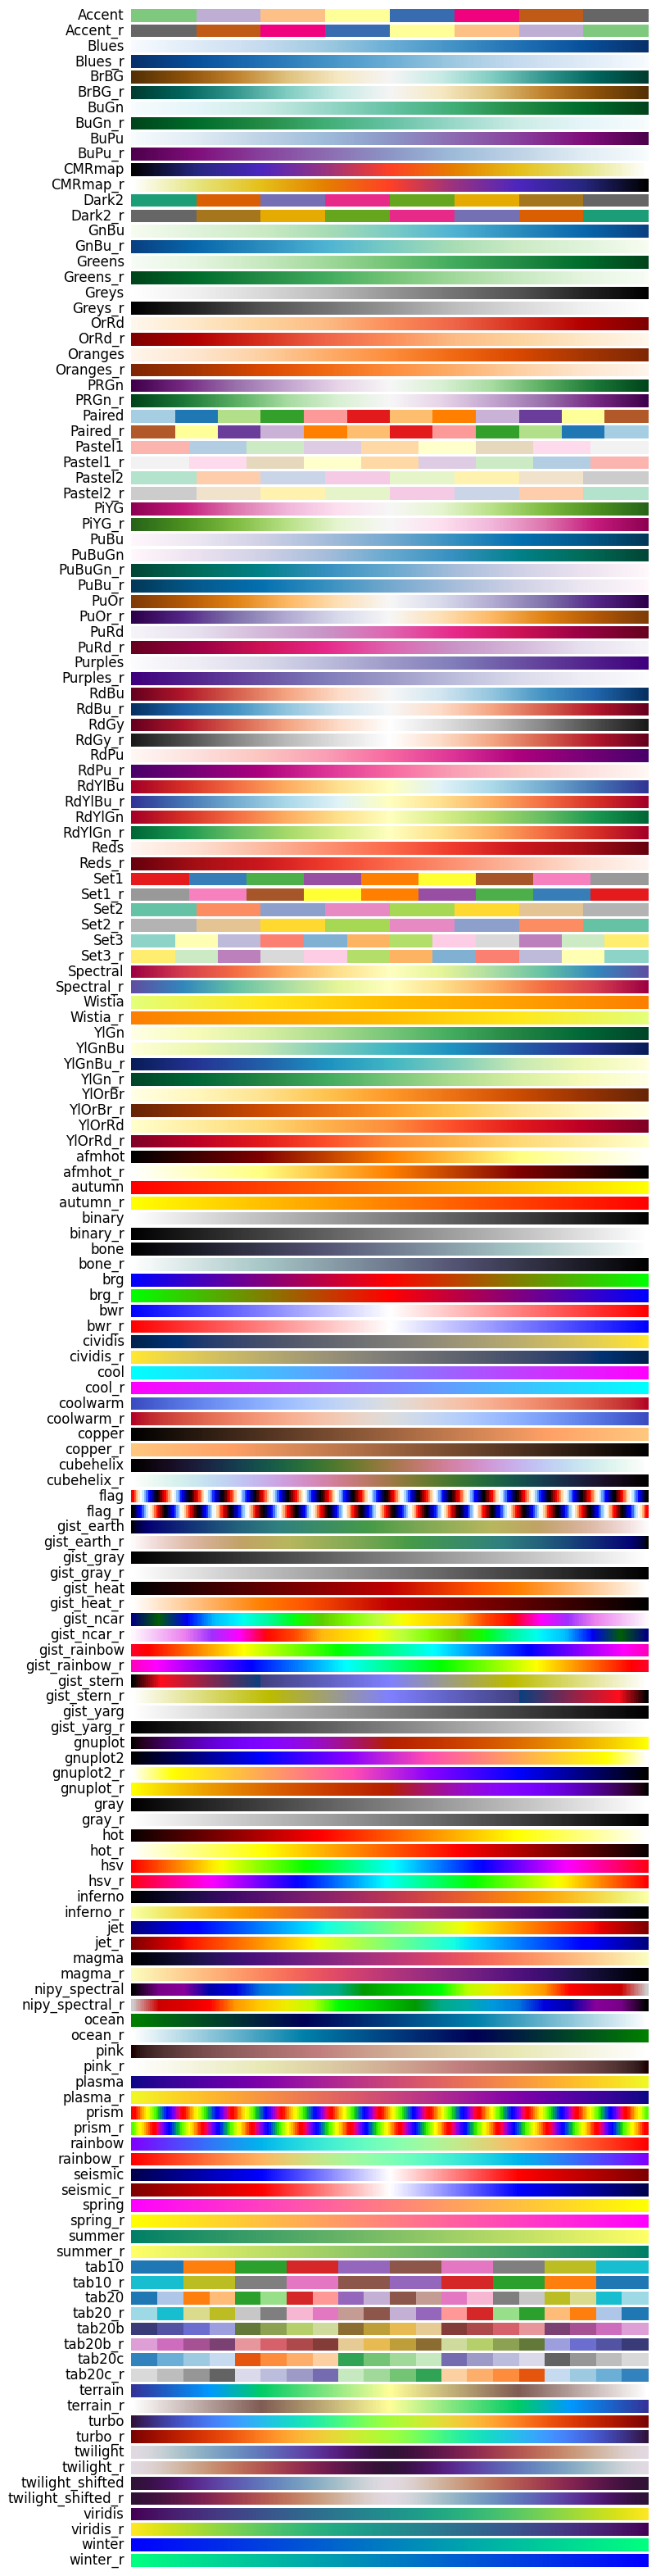

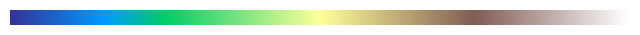

In [37]:
cm.plot_colormaps(width=8.0, height=0.2)
cm.plot_colormap('terrain',
                 width=8.0, height=0.2, orientation='horizontal')

In [55]:
# bio01(연평균기온) 레이어
min_val = predictors.select("bio01").multiply(0.1). \
reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio01").multiply(0.1). \
reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

# Vworld 레이어 설정을 변수로 저장
vworld_base_url = 'https://xdworld.vworld.kr/2d/Base/service/{z}/{x}/{y}.png'
vworld_base_name = 'Vworld Base'
vworld_base_attribution = 'Vworld'

# Vworld 레이어 추가
Map.add_tile_layer(
    url=vworld_base_url,
    name=vworld_base_name,
    attribution=vworld_base_attribution,
    shown=True
)

vis_params = {'min': math.floor(min_val['bio01']), \
              'max': math.ceil(max_val['bio01']),
              'palette': cm.palettes.hot}
Map.addLayer(predictors.select("bio01").multiply(0.1),
             vis_params, 'bio01')
Map.add_colorbar(vis_params,
                 label="Mean temperature of driest quarter (℃)",
                 orientation="vertical", layer_name="bio01")
Map.centerObject(AOI, 6)
Map


Map(center=[36.529621786200934, 127.85645081415706], controls=(WidgetControl(options=['position', 'transparent…

In [58]:
# TCC(수목피복 레이어)
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
# Vworld 레이어 추가
Map.add_tile_layer(
    url=vworld_base_url,
    name=vworld_base_name,
    attribution=vworld_base_attribution,
    shown=True
)

vis_params = {'bands':['TCC'], 'min': 0, 'max': 100,
              'palette':
               ['ffffff', 'afce56', '5f9c00', '0e6a00', '003800']}
Map.addLayer(predictors, vis_params, 'TCC')
Map.add_colorbar(vis_params, label="Tree Canopy Cover (%)",
                 orientation="vertical", layer_name="TCC")
Map.centerObject(AOI, 6)
Map


Map(center=[36.529621786200934, 127.85645081415706], controls=(WidgetControl(options=['position', 'transparent…

# 4. Generate Pseudo-Absence Data

In [59]:
# 100개의 출현 위치 무작위로 선택
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

In [60]:
# k-means 클러스터링
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

Clresult = predictors.cluster(clusterer)

# 출현 위치와 유사한 클러스터 ID
clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

# 유사하지 않은 클러스터에서 임의-비출현 영역 정의
clustID = ee.FeatureCollection(clustID). \
reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)


In [64]:
# 출현 위치 마스크
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None,
            ee.Number(GrainSize)).mask().neq(1).selfMask()

AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(AOI, 6)
Map


Map(center=[36.529621786200934, 127.85645081415706], controls=(WidgetControl(options=['position', 'transparent…

# 5. Fit SDM Model

In [84]:
def createGrid(geometry, scale):
    # 관심 지역의 경계를 기반으로 격자를 생성
    grid = ee.Image().toByte().paint(geometry, 1).reproject('EPSG:4326', None, scale)
    vectors = grid.reduceToVectors(
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        scale=scale,
        maxPixels=1e8,
        geometry=geometry
    )
    return vectors

Scale = 50000
grid = makeGrid(AOI, Scale)
Grid = watermask.reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

In [108]:
# 알고리즘 생성(랜덤포레스트)
Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500,
        variablesPerSplit=None,
        minLeafPopulation=10,
        bagFraction=0.5,
        maxNodes=None,
        seed=Seed)

In [113]:
split = 0.7
numiter = 10
runif = lambda length: [random.randint(1, 1000) \
                        for _ in range(length)]
items = runif(numiter)
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

# Fit SDM
results = eeSDM.batchSDM(Grid, Data, AreaForPA, GrainSize, bands, predictors, numiter, split=0.7, seed=None)

# 6. Map

In [117]:
# 서식지 적합성 지도(Habitat suitability map)
images = ee.List.sequence(1, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()
Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#440154', '#482677', '#404788', '#33638D', '#287D8E',
          '#1F968B', '#29AF7F', '#55C667', '#95D840', '#DCE319']}
Map = geemap.Map()
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability", orientation="horizontal", layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(Data.geometry(), 7)
Map

EEException: No valid training data were found.

In [118]:
# 잠재적 분포 지도(Potential distribution map)
images2 = ee.List.sequence(2, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

EEException: No valid training data were found.

# 7. Calculate Variable Importance

In [100]:
# Plot Average Variable Importance
eeSDM.plot_avg_variable_importance(results, numiter)

EEException: No valid training data were found.

# 8. Accuracy Assessment

In [119]:
# Testing datasets
TestingDatasets = (ee.List.sequence(4, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x)))

# Checking if there are sufficient presence and pseudo-absence points
eeSDM.print_pres_abs_sizes(TestingDatasets, numiter)

EEException: No valid training data were found.

In [ ]:
%%time

# Calculate AUC-ROC and AUC-PR
eeSDM.calculate_and_print_auc_metrics(images, TestingDatasets, GrainSize, numiter)

In [ ]:
%%time

# Calculate Sensitivity and Specificity
eeSDM.calculate_and_print_ss_metrics(images, TestingDatasets, GrainSize, numiter)

In [ ]:
%%time

# Plot ROC and PR curves
eeSDM.plot_roc_pr_curves(images, TestingDatasets, GrainSize, numiter)

In [ ]:
%%time

# Potential Distribution Map using the optimal threshold
DistributionMap2 = eeSDM.create_DistributionMap2(images, TestingDatasets, GrainSize, numiter, ModelAverage)

In [ ]:
out_dir = 'D:/GEODATA'

# Save Habitat Suitability Map as GeoTIFF
out_file = os.path.join(out_dir, 'habitat_suitability.tif')
geemap.ee_export_image(ModelAverage, filename=out_file, region=AOI, scale=1000)

# Save Potential Distribution Map as GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map.tif')
geemap.ee_export_image(DistributionMap, filename=out_file, region=AOI, scale=1000)

# Save Potential Distribution Map with Optimal Threshold as GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map2.tif')
geemap.ee_export_image(DistributionMap2, filename=out_file, region=AOI, scale=1000)